In [2]:
import copy
from pathlib import Path
import warnings
import os

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
import tensorboard as tb

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE, MultivariateNormalDistributionLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data import TorchNormalizer

from dataloader import TimeSeriesLoader

In [2]:
# suppose the raw dataset is downloaded and unzipped under Open-source-power-dataset
# data loaders are iterable
loader = TimeSeriesLoader(task='forecasting', root='../PSML')
train_loader, test_loader = loader.load(batch_size=32, shuffle=True)

0/66


# Process

1. Shape dataset (from csvs) per instrucitons in `pytorch-forecasting` docs into a `TimeSeriesDataset`
2. Batch via DataLoader per tutorial

In [3]:
data_original = pd.read_csv('../PSML/Minute-level Load and Renewable/CAISO_zone_1_.csv')

In [4]:
data_original.shape

(1573923, 12)

In [5]:
root = '../PSML'
data_folder = os.path.join(root, 'processed_dataset', 'forecasting')
location = 'CAISO_zone_1'
years = ['2018', '2019', '2020']

data = pd.DataFrame()
data_dfs = []

for year in years:
    data_append = pd.read_csv(os.path.join(data_folder, f'{location}_{year}.csv'))
    data_dfs.append(data_append)
    data = pd.concat((data, data_append), ignore_index=True)

data_2018 = data_dfs[0]
data_2019 = data_dfs[1]
data_2020 = data_dfs[2]
data['ID'] = data.index
data

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(val),yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.880,1.2,...,0.004626,1.0,0.005297,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.842,1.2,...,0.004735,1.0,0.005203,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.804,1.2,...,0.004844,1.0,0.005109,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.766,1.2,...,0.004953,1.0,0.005015,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.728,1.2,...,0.005062,1.0,0.004921,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573918,1573918,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,169.010,0.8,...,-1.000000,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0
1573919,1573919,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.990,0.8,...,-1.000000,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0
1573920,1573920,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.970,0.8,...,-1.000000,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0
1573921,1573921,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.950,0.8,...,-1.000000,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573923 entries, 0 to 1573922
Data columns (total 28 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ID                  1573923 non-null  int64  
 1   month_day           1573923 non-null  float64
 2   weekday             1573923 non-null  float64
 3   holiday             1573923 non-null  float64
 4   DHI                 1573923 non-null  float64
 5   DNI                 1573923 non-null  float64
 6   GHI                 1573923 non-null  float64
 7   Dew Point           1573923 non-null  float64
 8   Solar Zenith Angle  1573923 non-null  float64
 9   Wind Speed          1573923 non-null  float64
 10  Relative Humidity   1573923 non-null  float64
 11  Temperature         1573923 non-null  float64
 12  yl_t                1573923 non-null  float64
 13  yl_t+60(val)        1573923 non-null  float64
 14  yl_t+60(flag)       1573923 non-null  float64
 15  yl_t+1440(val) 

Pick one of the tasks and train a model based on it. We'll use hourly load prediction.

In [7]:
data.groupby('yl_t+60(val)', axis=0).count().sort_values(by='ID', ascending=False)

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(val),yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag
yl_t+60(val),,,,,,,,,,,,,,,,,,,,,
-1.000000,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
0.894030,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
0.779754,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1.019711,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
0.926508,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.881975,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.881975,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.881974,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [8]:
time_col = 'ID'
target_y = 'yl_t+60(flag)'
data_yl_t60 = data_2018[data_2018[target_y] == 1].reset_index(drop=True)
data_yl_t60['ID'] = data_yl_t60.index
data_yl_t60

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(val),yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.88,1.2,...,0.004626,1.0,0.005297,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-8.4,161.76,1.2,...,0.005005,1.0,0.005360,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-9.2,150.28,1.3,...,0.006226,1.0,0.005413,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-9.9,137.98,1.4,...,0.008069,1.0,0.006356,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-10.4,125.56,1.5,...,0.008007,1.0,0.007392,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,8730,12.967742,6.0,0.0,0.0,0.0,0.0,6.5,116.08,1.1,...,0.003698,1.0,0.005245,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8731,8731,12.967742,6.0,0.0,0.0,0.0,0.0,7.0,128.39,1.0,...,0.003795,1.0,0.003749,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8732,8732,12.967742,6.0,0.0,0.0,0.0,0.0,7.3,140.80,1.4,...,0.009405,1.0,0.008951,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8733,8733,12.967742,6.0,0.0,0.0,0.0,0.0,7.1,153.02,1.6,...,0.009906,1.0,0.010854,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
max_prediction_length = 24
max_encoder_length = 48
# training_cutoff = data[time_col].max() - max_prediction_length

training = TimeSeriesDataSet(
    data_2018[data_2018['month_day'] < 10],
    time_idx=time_col,
    target=target_y,
    group_ids=['month_day', 'weekday'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['holiday'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'DHI',
        'DNI',
        'GHI',
        'Dew Point',
        'Solar Zenith Angle',
        'Wind Speed',
        'Relative Humidity',
        'Temperature',
        target_y,
    ],
    target_normalizer=TorchNormalizer(
        method='identity', center=True, transformation=None, method_kwargs={}
    ), # https://github.com/jdb78/pytorch-forecasting/issues/1220
#     add_relative_time_idx=True,
    add_target_scales=True,
#     add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data_2018[data_2018['month_day'] < 12], stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, data_2018[data_2018['month_day'] >= 12])

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, pin_memory=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, pin_memory=True)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, pin_memory=True)

### Find optimal learning rate

In [10]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42


MisconfigurationException: No supported gpu backend found!

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/changsun/Documents/CS7643_DL/Renewable-load-forecasting/Code/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.15135612484362077
Restoring states from the checkpoint path at /home/changsun/Documents/CS7643_DL/Renewable-load-forecasting/Code/.lr_find_94fd06c0-ccf9-44e7-afac-03975280590e.ckpt
Restored all states from the checkpoint at /home/changsun/Documents/CS7643_DL/Renewable-load-forecasting/Code/.lr_find_94fd06c0-ccf9-44e7-afac-03975280590e.ckpt


suggested learning rate: 0.15135612484362077


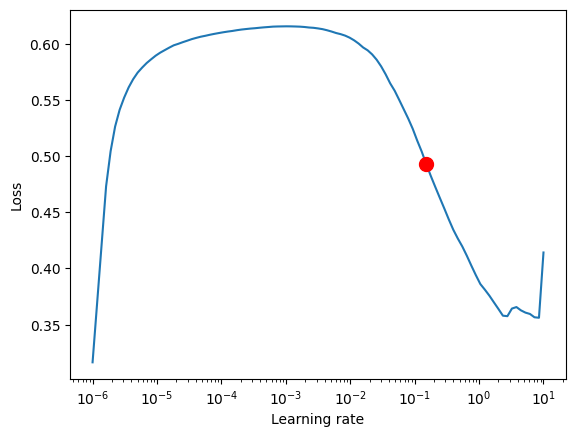

In [76]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [77]:
optimal_lr = 0.1

In [11]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=optimal_lr,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

MisconfigurationException: No supported gpu backend found!

In [12]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

NameError: name 'trainer' is not defined